# Imports

In [191]:
! pip install jsonlines

sh: 0: getcwd() failed: No such file or directory
The folder you are executing pip from can no longer be found.


In [161]:
import json
import os
import pickle
import random
from time import gmtime
from time import strftime

import boto3
import jsonlines
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sagemaker
from sagemaker.debugger import Rule
from sagemaker.debugger import rule_configs
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.predictor import Predictor
from sagemaker.session import TrainingInput
from sagemaker.s3 import S3Downloader
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker.serializers import IdentitySerializer

# Workspace

In [77]:
sess = sagemaker.Session()

In [80]:
bucket = sess.default_bucket()
region = sess.boto_region_name
role = sagemaker.get_execution_role()

print(f'Default Bucket: {bucket}')
print(f'AWS Region: {region}')
print(f'RoleArn: {role}')

Default Bucket: sagemaker-us-east-1-013268419919
AWS Region: us-east-1
RoleArn: arn:aws:iam::013268419919:role/service-role/AmazonSageMaker-ExecutionRole-20210829T170717


In [81]:
os.environ["DEFAULT_S3_BUCKET"] = bucket

In [113]:
BASE_URL = f"s3://{bucket}"

# Data

In [1]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz

--2021-09-13 12:54:08--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  84.0MB/s    in 1.9s    

2021-09-13 12:54:11 (84.0 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]



In [3]:
! tar -xvf cifar-100-python.tar.gz && rm cifar-100-python.tar.gz

cifar-100-python/
cifar-100-python/file.txt~
tar: cifar-100-python/file.txt~: Cannot change ownership to uid 1000, gid 1000: Operation not permitted
cifar-100-python/train
tar: cifar-100-python/train: Cannot change ownership to uid 1000, gid 1000: Operation not permitted
cifar-100-python/test
tar: cifar-100-python/test: Cannot change ownership to uid 1000, gid 1000: Operation not permitted
cifar-100-python/meta
tar: cifar-100-python/meta: Cannot change ownership to uid 1000, gid 1000: Operation not permitted
tar: cifar-100-python: Cannot change ownership to uid 1000, gid 1000: Operation not permitted
tar: Exiting with failure status due to previous errors


In [5]:
def unload_dataset(path: str):
    """
    Unpickles the dataset at given path
    """
    with open(path, "rb") as f:
        return pickle.load(f, encoding="bytes")

In [6]:
dataset_meta = unload_dataset("./cifar-100-python/meta")
dataset_train = unload_dataset("./cifar-100-python/train")
dataset_test = unload_dataset("./cifar-100-python/test")

In [8]:
dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

# Data Exploration, Transformation & Loading

In [45]:
type(dataset_train[b'data'])

numpy.ndarray

In [44]:
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

In [48]:
def clean_data(data: pd.DataFrame, allowed_labels: list = None) -> pd.DataFrame:
    """
    * Removes rows where label != 8 or 48
    * Decodes filenames to regular str
    """
    allowed_labels = allowed_labels or ["8", "48"]
    temp = data.loc[data['labels'].isin(allowed_labels)]
    idx = list(temp.index)
    temp = temp.reset_index()
    temp["filenames"] = temp["filenames"].apply(lambda x: x.decode("utf-8"))
    return temp, idx

In [64]:
def save_images(dataset: dict, data: np.ndarray, output_dir=str, verbose: bool=False) -> None:
    """
    
    """
    os.makedirs(output_dir, exist_ok=True)
    for filename, image in zip(dataset['filenames'], data):
        channels = [
            image[1024*x:1024*(x+1)] for x in range(3)
        ]
        combined = np.dstack([channel.reshape(32, 32) for channel in channels])
        plt.imsave(os.path.join(output_dir, filename), combined)
        if verbose:
            print(f"Saved {filename} to {output_dir}")

In [60]:
df_train_clean, train_idx = clean_data(df_train)
df_test_clean, test_idx = clean_data(df_test)

In [68]:
save_images(
    df_train_clean, dataset_train[b'data'], output_dir="train"
)

In [67]:
save_images(
    df_test_clean, dataset_test[b'data'], output_dir="test"
)

In [ ]:
! aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/ > train.log 2>&1
! aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/ > test.log 2>&1

# Training

In [85]:
def create_metadata_file(df: pd.DataFrame, prefix: str) -> None:
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )

In [86]:
create_metadata_file(df_train_clean, "train")
create_metadata_file(df_test_clean, "test")

In [91]:
(boto3.Session()
 .resource("s3")
 .Bucket(bucket)
 .Object("train.lst")
 .upload_file("./train.lst"))

In [92]:
(boto3.Session()
 .resource("s3")
 .Bucket(bucket)
 .Object("test.lst")
 .upload_file("./test.lst"))

In [94]:
algo_image = sagemaker.image_uris.retrieve(
    framework="image-classification", region=region)

In [95]:
s3_output_location = BASE_URL + "/models/image_model"

In [104]:
# https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_debugger.html#continuous-analyses-through-rules
debugger_rules = [
    rule_configs.vanishing_gradient(),
    rule_configs.weight_update_ratio(),
    rule_configs.loss_not_decreasing(),
    rule_configs.overtraining()
]

In [110]:
model = Estimator(
    image_uri=algo_image,
    role=role,
    instance_count=1,
    instance_type="ml.p2.xlarge",
    output_path=s3_output_location,
    sagemaker_session=sess,
    rules=[
        Rule.sagemaker(rule) for rule in debugger_rules
    ]
)

In [121]:
model.set_hyperparameters(
    image_shape="3,32,32",
    num_classes=2,
    num_training_samples=len(df_train_clean),
    use_pretrained_model=0
)

In [116]:
model_inputs = {
    "train": TrainingInput(
        s3_data=f"{BASE_URL}/train/",
        content_type="application/x-image"
    ),
    "validation": TrainingInput(
        s3_data=f"{BASE_URL}/test/",
        content_type="application/x-image"
    ),
    "train_lst": TrainingInput(
        s3_data=f"{BASE_URL}/train.lst",
        content_type="application/x-image"
    ),
    "validation_lst": TrainingInput(
        s3_data=f"{BASE_URL}/test.lst",
        content_type="application/x-image"
    )
}

In [ ]:
model.fit(inputs=model_inputs, logs="All")

2021-09-13 18:32:07 Starting - Starting the training job...
2021-09-13 18:32:13 Starting - Launching requested ML instancesVanishingGradient: InProgress
WeightUpdateRatio: InProgress
LossNotDecreasing: InProgress
Overtraining: InProgress
ProfilerReport-1631557927: InProgress
.........
2021-09-13 18:34:01 Starting - Preparing the instances for training.........
2021-09-13 18:35:28 Downloading - Downloading input data......
2021-09-13 18:36:22 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[09/13/2021 18:36:49 INFO 140489187047232] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'fl

# Deployment

In [128]:
endpoint_name = "awako-endpoint-"+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)

awako-endpoint-2021-09-13-18-56-11


In [130]:
data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"{BASE_URL}/data_capture"
)

In [138]:
deployment = model.deploy(
    instance_type="ml.p2.xlarge",
    initial_instance_count=1,
    endpoint_name=endpoint_name,
    data_capture_config=data_capture_config
)

-----------------!

# Inference

In [135]:
serializer = IdentitySerializer("image/png")

In [139]:
predictor = Predictor(
    endpoint_name=endpoint_name,
    session=sess,
    serializer=serializer
)

In [140]:
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()

response = predictor.predict(data=payload)
print(response)

b'[0.500469446182251, 0.499530553817749]'


# Testing & Evaluation

In [159]:
def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    objects = s3.Bucket(bucket).objects.filter(Prefix="test/bicycle")
    
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })

In [179]:
generate_test_case()

'{"image_data": "", "s3_bucket": "sagemaker-us-east-1-013268419919", "s3_key": "test/bicycle_s_001789.png"}'

In [186]:
s3_client = boto3.Session().client('s3')
result = s3_client.list_objects(Bucket=bucket, Prefix="data_capture")
capture_files = [capture_file.get("Key") for capture_file in result.get('Contents')]

In [189]:
for file in capture_files:
    filename = file.split("/")[-1]
    s3_client.download_file(bucket, file, f"captured_data/{filename}")

In [9]:
import os
import json
import jsonlines
import matplotlib.pyplot as plt

In [3]:
# List the file names we downloaded
file_handles = os.listdir("./captured_data")

# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    with jsonlines.open(f"./captured_data/{jsonl}") as f:
        json_data.append(f.read())

In [6]:
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[0])

([0.43780553340911865, 0.5621944665908813], '2021-09-13T22:26:40Z')

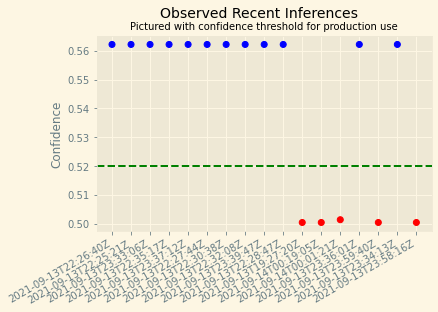

In [11]:
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

# Todo: here is an visualization example, take some time to build another visual that helps monitor the result
# Plot the data
plt.scatter(x, y, c=['r' if k< .52 else 'b' for k in y ])
plt.axhline(y=0.52, color='g', linestyle='--')
# plt.ylim(bottom=.88)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()